First, we'll try to generate some images using a pre-trained [network](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2).  We will stylize VR images from [Flickr](https://www.flickr.com/groups/equirectangular/) and view them in VR to make sure that they look reasonable...

In [3]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [4]:
STYLE_PATH = tf.keras.utils.get_file(
    'kandinsky5.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'
)

In [17]:
?tf.keras.utils.get_file

In [5]:
def load_img(path_to_img, max_dim=256):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [6]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)

    if title:
        plt.title(title)

In [7]:
style_image = load_img(STYLE_PATH)

In [8]:
import tensorflow_hub as hub

CONTENT_PATH = "/Users/siddhantjagadish/Downloads/canalscape.jpg" 


def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
    tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def style_transfer(content_image, style_image):
    hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
    stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
    return stylized_image

def create_and_save_image(content_path, style_image, content_size, out_path=None):
    print("Loading Content Image...")
    content_image = load_img(content_path, content_size)
    print ("Conducting Style Transfer...")
    stylized_image = style_transfer(content_image, style_image)
    pil_stylized_image = tensor_to_image(stylized_image)
    if out_path:
        print ("Saving Output Image to %s" % str(out_path))
        with open(out_path, 'w') as wr:
            pil_stylized_image = pil_stylized_image.save(out_path)
    return stylized_image, pil_stylized_image

First we'll try to generate images for each of a number of output file sizes to see what's necessary to be usable in VR.

In [9]:
import os

PARENT_PATH = os.path.abspath("/Users/siddhantjagadish/Documents/DataProjects/vr_visualizer2/vr_images/")

'''
# Run Already
for out_size in (512, 1024, 2048, 4096):
    create_and_save_image(
        CONTENT_PATH,
        style_image,
        out_size, 
        get_path('kandinsky_canal', SIZE)
    )
'''

    
def get_path(prefix, size):
    return os.path.join(PARENT_PATH, "%s_%d.jpg" % (prefix, size))

Based on the output we've seen, it seems like we need at least 4096 * 2048 for things not to appear blurry in VR.  Let's take a look at one of the images we've produced.

Loading Content Image...
Conducting Style Transfer...


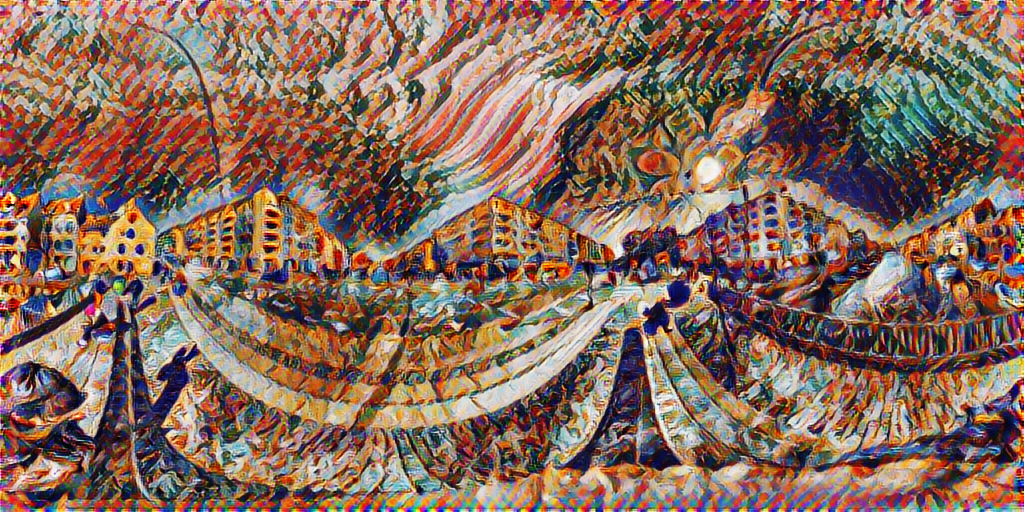

In [10]:
tf_img, pil_img = create_and_save_image(
    CONTENT_PATH,
    style_image,
    1024 
)
pil_img

Sweet, it appears to be working reasonably well...Let's try to do this with another style image, this time a Thomas Hart Benton image

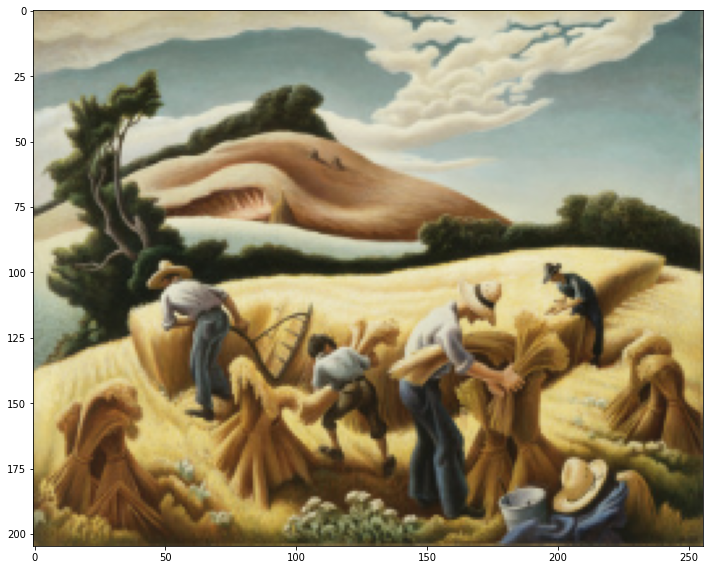

In [11]:
thb = load_img("/Users/siddhantjagadish/Documents/DataProjects/vr_audio_visualizer/base_images/style_images/thomas_hart_benton.jpg")
imshow(thb)

Let's save this visualization so we can see it in VR too...

In [12]:
_stylized_img, _ =create_and_save_image(
    CONTENT_PATH,
    thb,
    4096,
    # get_path('thb_canal', 4096)  # Already saved
)
imshow(_stylized_img)

Loading Content Image...
Conducting Style Transfer...


(<tf.Tensor: shape=(1, 2048, 4096, 3), dtype=float32, numpy=
 array([[[[0.9193915 , 0.95719916, 0.92793083],
          [0.93694437, 0.9666421 , 0.9456337 ],
          [0.9298547 , 0.9598499 , 0.93913865],
          ...,
          [0.76684886, 0.8656765 , 0.8683247 ],
          [0.75105727, 0.8702463 , 0.87864697],
          [0.7310047 , 0.85911286, 0.8763197 ]],
 
         [[0.9576828 , 0.977979  , 0.9643805 ],
          [0.9654264 , 0.98203975, 0.9713797 ],
          [0.9612213 , 0.97787434, 0.96737635],
          ...,
          [0.84716386, 0.91249317, 0.9156504 ],
          [0.8511699 , 0.92520285, 0.93071246],
          [0.83713716, 0.9190562 , 0.9273223 ]],
 
         [[0.9481829 , 0.9699386 , 0.95041275],
          [0.95347464, 0.97299373, 0.9558626 ],
          [0.9463319 , 0.9664157 , 0.9478587 ],
          ...,
          [0.8233402 , 0.88507855, 0.8839395 ],
          [0.84428203, 0.91135967, 0.9142678 ],
          [0.82770336, 0.9051769 , 0.9105629 ]],
 
         ...,
 
     

Now let's try to interpolate between the two to see what that looks like...

Loading Content Image...
Conducting Style Transfer...


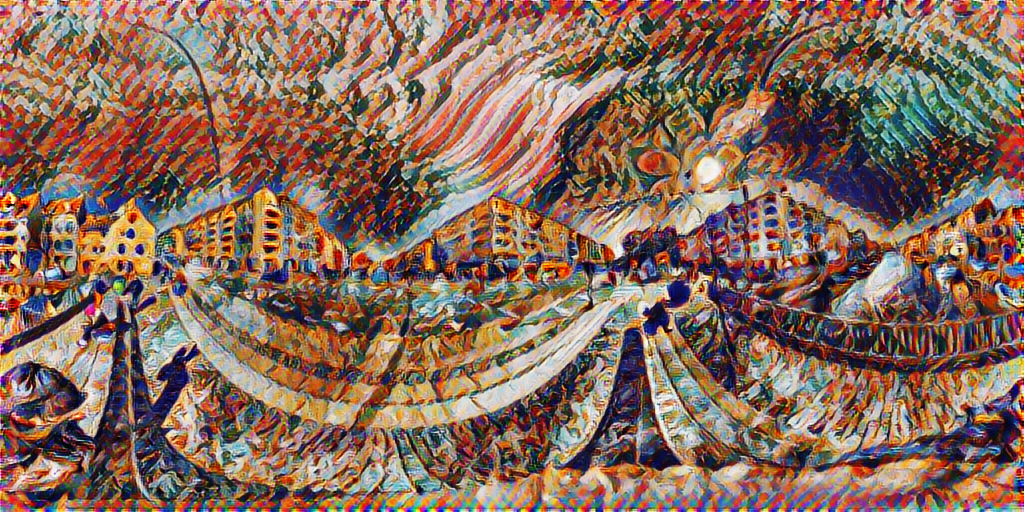

In [13]:
kandinsky_1024, pil_kandinsky_1024 = create_and_save_image(
    CONTENT_PATH,
    style_image,
    1024, 
)
pil_kandinsky_1024

Loading Content Image...
Conducting Style Transfer...


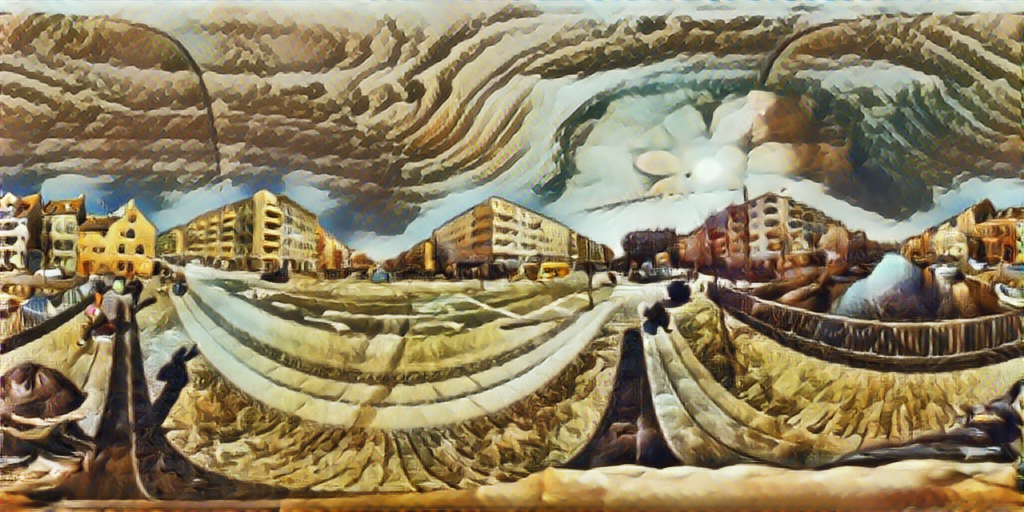

In [14]:
thb_1024, pil_thb_1024 = create_and_save_image(
    CONTENT_PATH,
    thb,
    1024, 
)
pil_thb_1024

10% of the way

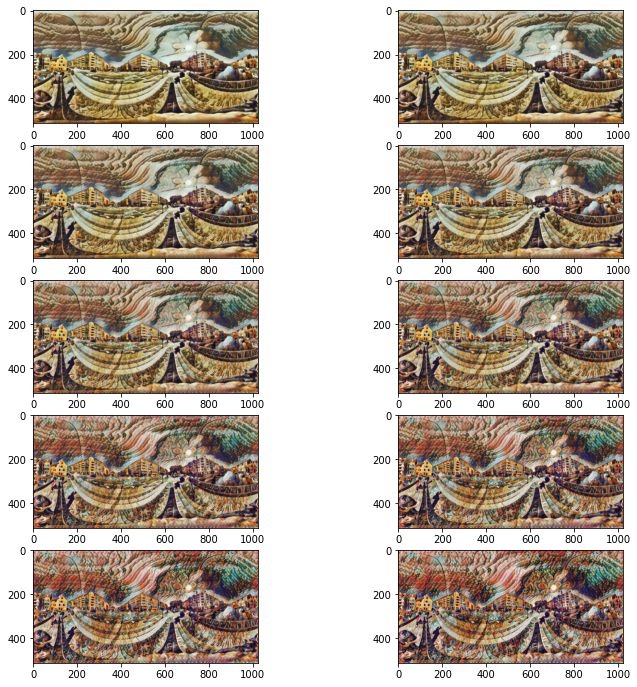

In [15]:
N_PROPS = 10 

proportions = np.linspace(0, 1., N_PROPS)
for idx, prop in enumerate(proportions):
    cur_image = prop * kandinsky_1024 + (1. - prop) * thb_1024
    plt.subplot(N_PROPS / 2, 2, idx + 1)
    imshow(cur_image)

Above, it looks like it interpolation should work reasonably well...Let's upload the large versions of these...and see what interpolation is all about in VR!

In [118]:
kandinsky_4096, _ = create_and_save_image(
    CONTENT_PATH,
    style_image,
    4096, 
)

Loading Content Image...
Conducting Style Transfer...


In [119]:
thb_4096, _ = create_and_save_image(
    CONTENT_PATH,
    thb,
    4096, 
)

Loading Content Image...
Conducting Style Transfer...


In [126]:
N_PROPS = 10 

proportions = np.linspace(0, 1., N_PROPS)
for idx, prop in enumerate(proportions):
    cur_image = prop * kandinsky_4096 + (1. - prop) * thb_4096
    cur_pil_image = tensor_to_image(cur_image)
    cur_path = os.path.join(
        PARENT_PATH,
        "kandinsky_thb_%d.jpg" % int(100 * prop)
    )
    with open(cur_path, 'w') as wr:
        cur_pil_image.save(wr)

I tried out the interpolations in VR and they seemed to work well!!!  Let's try to create a short video to see what a transition might look like...

In [16]:
class InterpolationVideoCreator(object):

    def __init__(
        self,
        im1,
        im2,
        out_path,
        fps=30,
        padding=4
    ):
        self.im1 = im1
        self.im2 = im2
        self.fps = fps
        self.image_index = 0 
        self.out_path = out_path
        self.padding = padding
        
    def get_file_path(self, counter):
        suffix = "img_%s.jpg" % str(self.image_index).zfill(self.padding)
        return os.path.join(self.out_path, suffix)

    def add_video_segment(
        self,
        proportions
    ):
        counter = 0
        while counter < len(proportions):
            cur_proportion = proportions[counter]
            cur_image = cur_proportion * self.im1 + (1. - cur_proportion) * self.im2
            cur_pil_image = tensor_to_image(cur_image)
            with open(self.get_file_path(counter), 'w') as wr:
                cur_pil_image.save(wr)
            counter += 1
            self.image_index += 1
    
    def add_linear_video_segment(
        self,
        ascending=True,
        start_prop=0.,
        end_prop=1.,
        n_seconds=1.
    ):
        # Adds a linear video segment
        n_images = int(n_seconds * self.fps)
        if not ascending:
            start_prop = 1. - start_prop
            end_prop = 1. - end_prop
        proportions = np.linspace(start_prop, end_prop, n_images)
        self.add_video_segment(proportions)
            
    def add_functional_video_segment(
        self,
        ascending=True,
        start_prop=0.,
        end_prop=1.,
        n_seconds=1.,
        noise_amplitude=0.,
        noise_frequency=20.
    ):
        n_frames = int(n_seconds * self.fps)
        pi_converter = np.pi / 2
        if ascending:
            raw_proportions = np.linspace(0, 1, n_frames)
        else:
            raw_proportions = np.linspace(1, 0, n_frames)
        sin_proportions = np.sin(pi_converter * raw_proportions)
        noise_proportions = noise_amplitude * np.sin(pi_converter * raw_proportions * noise_frequency)
        proportions = sin_proportions + noise_proportions
        self.add_video_segment(proportions)

In [218]:
kandinsky_3840, _ = create_and_save_image(
    CONTENT_PATH,
    style_image,
    3840
)
thb_3840, _ = create_and_save_image(
    CONTENT_PATH,
    thb,
    3840
)

Loading Content Image...
Conducting Style Transfer...
Loading Content Image...
Conducting Style Transfer...


In [221]:
# TODO: Shouldn't actually be 4096 for oculus, should be 3840
# Oculus wants 20mb / s bit rate

ivc = InterpolationVideoCreator(
    kandinsky_3840,
    thb_3840,
    os.path.abspath("/Users/siddhantjagadish/Documents/DataProjects/vr_audio_visualizer/video_files/kandinsky_thb_transition/")
)
ivc.add_functional_video_segment(n_seconds=3, noise_amplitude=0.2, noise_frequency=20)
ivc.add_functional_video_segment(n_seconds=3, noise_amplitude=0.2, noise_frequency=80, ascending=False)
ivc.add_functional_video_segment(n_seconds=3, noise_amplitude=0.5, noise_frequency=20)
ivc.add_functional_video_segment(n_seconds=3, noise_amplitude=0.5, noise_frequency=80, ascending=False)
ivc.add_linear_video_segment(n_seconds=1)
ivc.add_linear_video_segment(n_seconds=1, ascending=False)
ivc.add_linear_video_segment(n_seconds=2)
ivc.add_linear_video_segment(n_seconds=2, ascending=False)
ivc.add_linear_video_segment(n_seconds=3)
ivc.add_linear_video_segment(n_seconds=3, ascending=False)

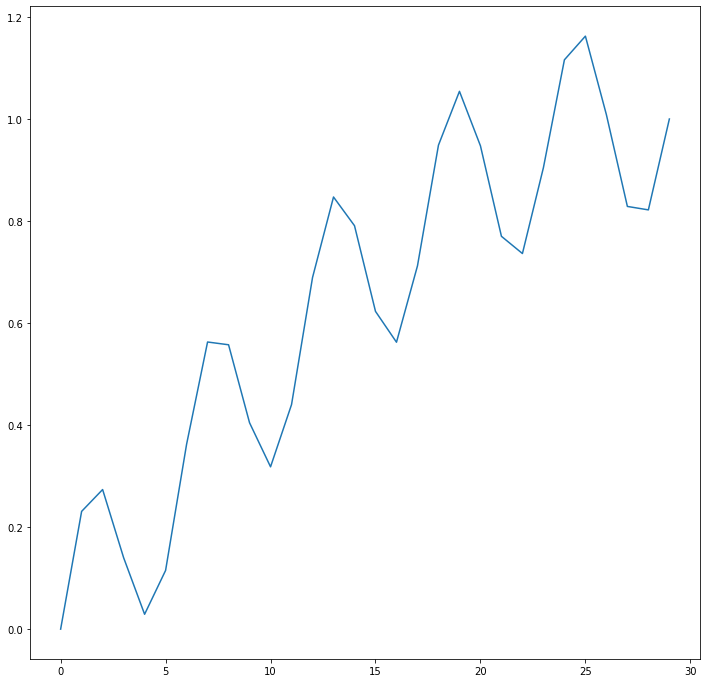

In [215]:
_y = ivc.add_functional_video_segment(noise_amplitude=0.2)
_x = np.arange(len(_y))
plt.plot(_x, _y)

In [201]:
_y

array([0.        , 0.00180551, 0.00361103, 0.00541654, 0.00722205,
       0.00902757, 0.01083308, 0.01263859, 0.0144441 , 0.01624962,
       0.01805513, 0.01986064, 0.02166616, 0.02347167, 0.02527718,
       0.0270827 , 0.02888821, 0.03069372, 0.03249923, 0.03430475,
       0.03611026, 0.03791577, 0.03972129, 0.0415268 , 0.04333231,
       0.04513783, 0.04694334, 0.04874885, 0.05055436, 0.05235988])

Let's start with a 1s transition...

In [153]:
ivc.add_video_segment()

Now let's get that shit in reverse...

In [154]:
ivc.add_video_segment(ascending=False)

In [164]:
ivc.add_video_segment(n_seconds=5)

In [165]:
ivc.add_video_segment(n_seconds=5, ascending=False)

Now let's try to just make a couple quick videos of transitions and see what happens... 

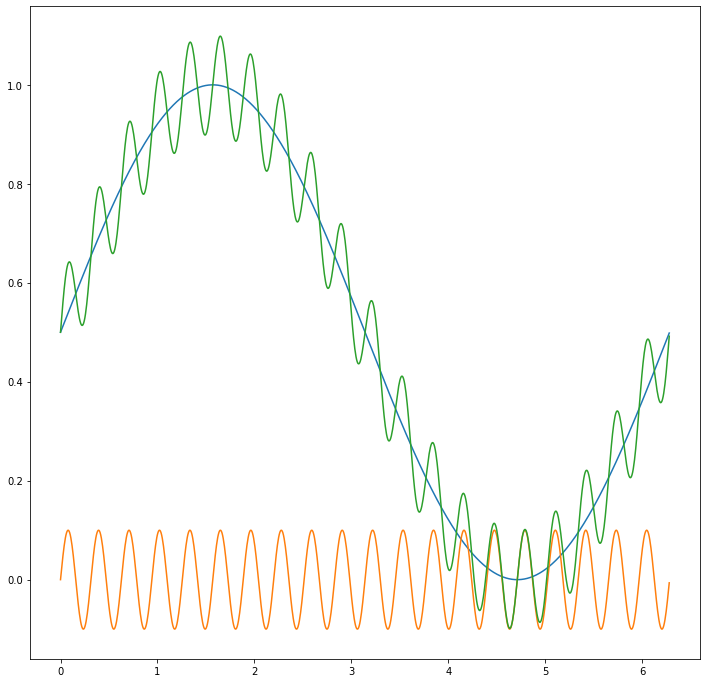

In [177]:
_x = np.linspace(0., 6.28, 1000)
_y = 0.5 * (1. + np.sin(_x))
_z = 0.1 * np.sin(20 * _x)
plt.plot(_x, _y)
plt.plot(_x, _z)
plt.plot(_x, _y + _z)

#### Let's Try One Other Content Image

We'll try one more image, an [image of a landscape in Greece](https://flickr.com/photos/171098105@N05/49640214436/in/pool-equirectangular/)

In [222]:
?create_and_save_image

In [226]:
GREECE_PATH = "/Users/siddhantjagadish/Documents/DataProjects/vr_audio_visualizer/base_images/content_images/greece_landscape.jpg"

greece_kandinsky, _ = create_and_save_image(
    GREECE_PATH,
    style_image,
    4096,
    out_path=os.path.join(PARENT_PATH, 'greece_kandinsky_4096.jpg')
)

greece_thb, _ = create_and_save_image(
    GREECE_PATH,
    thb,
    4096,
    out_path=os.path.join(PARENT_PATH, 'greece_thb_4096.jpg')
)

Loading Content Image...
Conducting Style Transfer...
Saving Output Image to /Users/siddhantjagadish/Documents/DataProjects/vr_audio_visualizer/vr_images/greece_kandinsky_4096.jpg
Loading Content Image...
Conducting Style Transfer...
Saving Output Image to /Users/siddhantjagadish/Documents/DataProjects/vr_audio_visualizer/vr_images/greece_thb_4096.jpg
